In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')

# This notebook will do the following:
1. Dataset analysis
2. Feature analysis (categorical and numerical if applicable)
3. Data missingness
4. Correlation analysis
5. Model training

# Dataset analysis
1. Shape
2. Data types
3. Column names

In [3]:
df.shape

(2190, 13)

In [4]:
df_test.shape

(730, 12)

In [5]:
df.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall'],
      dtype='object')

In [6]:
df.dtypes

id                 int64
day                int64
pressure         float64
maxtemp          float64
temparature      float64
mintemp          float64
dewpoint         float64
humidity         float64
cloud            float64
sunshine         float64
winddirection    float64
windspeed        float64
rainfall           int64
dtype: object

In [7]:
df.duplicated().sum()

0

In [8]:
df.head(3)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1


In [9]:
df.tail(3)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1
2189,2189,365,1013.8,21.2,19.1,18.0,18.0,89.0,88.0,1.0,70.0,48.0,1


In [10]:
df.sample(3)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
328,328,329,1022.5,19.3,17.3,16.4,12.8,77.0,94.0,0.0,10.0,24.4,1
766,766,37,1026.5,15.0,13.6,11.2,6.4,69.0,88.0,0.2,20.0,32.2,1
266,266,267,1017.9,28.0,26.5,24.9,23.4,82.0,77.0,8.5,200.0,23.9,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB



# Observations
1. 11 features and 1 target
2. All features are numeric
3. Aside from day, all features are float values (non-categorical)
4. We will drop id


# Feature Analysis

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df.drop(columns='id').describe().style.background_gradient(cmap='cool')

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [14]:
df_test.drop(columns='id').describe().style.background_gradient(cmap='cool')

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,729.000000,730.000000
mean,183.000000,1013.503014,26.372466,23.963288,22.110274,20.460137,82.669863,76.360274,3.664384,103.923182,22.484247
std,105.438271,5.505871,5.672521,5.278098,5.170744,5.391169,7.818714,17.934121,3.639272,81.695458,9.954779
min,1.000000,1000.000000,7.400000,5.900000,4.200000,-0.000000,39.000000,0.000000,0.000000,10.000000,4.500000
25%,92.000000,1008.725000,21.600000,19.825000,17.825000,16.800000,77.250000,69.000000,0.325000,40.000000,14.500000
50%,183.000000,1012.700000,27.800000,25.650000,23.900000,22.300000,82.000000,83.000000,2.200000,70.000000,21.300000
75%,274.000000,1017.600000,31.000000,28.375000,26.400000,25.000000,89.000000,88.000000,6.675000,200.000000,28.400000
max,365.000000,1032.200000,35.800000,31.800000,29.100000,26.700000,98.000000,100.000000,11.800000,300.000000,59.500000


In [15]:
def num_col_analysis(df,cols):
    fig,axs = plt.subplots(len(cols),2,figsize=(10,len(cols)*3))
    for i,col in enumerate(cols):
        axs[i,0].set_title(f"Boxplot for {col}")
        sns.boxplot(df,x=col,ax=axs[i,0])
        axs[i,1].set_title(f"Histogram for {col}")
        sns.histplot(df,x=col,ax=axs[i,1],kde=True,hue='rainfall')
    plt.tight_layout()
    plt.show()

In [16]:
num_cols = df.drop(columns=['id']).columns

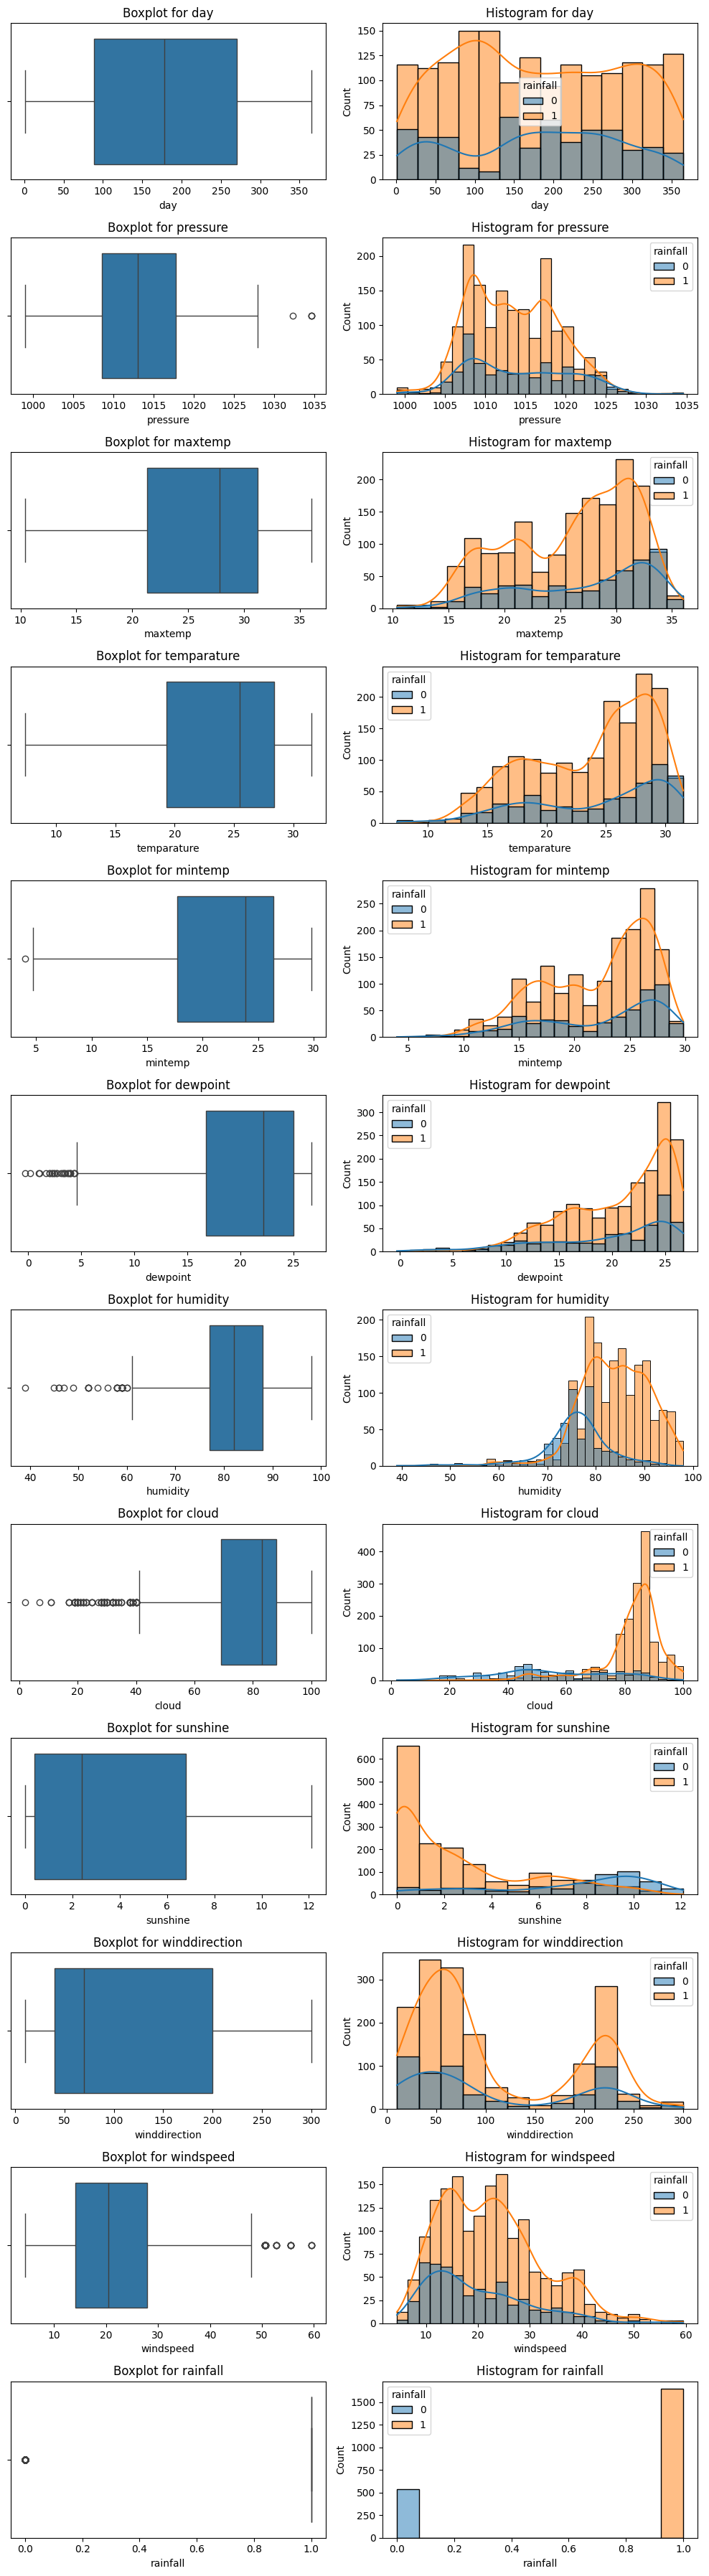

In [17]:
num_col_analysis(df,num_cols)

In [18]:
df_corr = df.drop(columns='id').corr()

<Axes: title={'center': 'Correlation Heatmap'}>

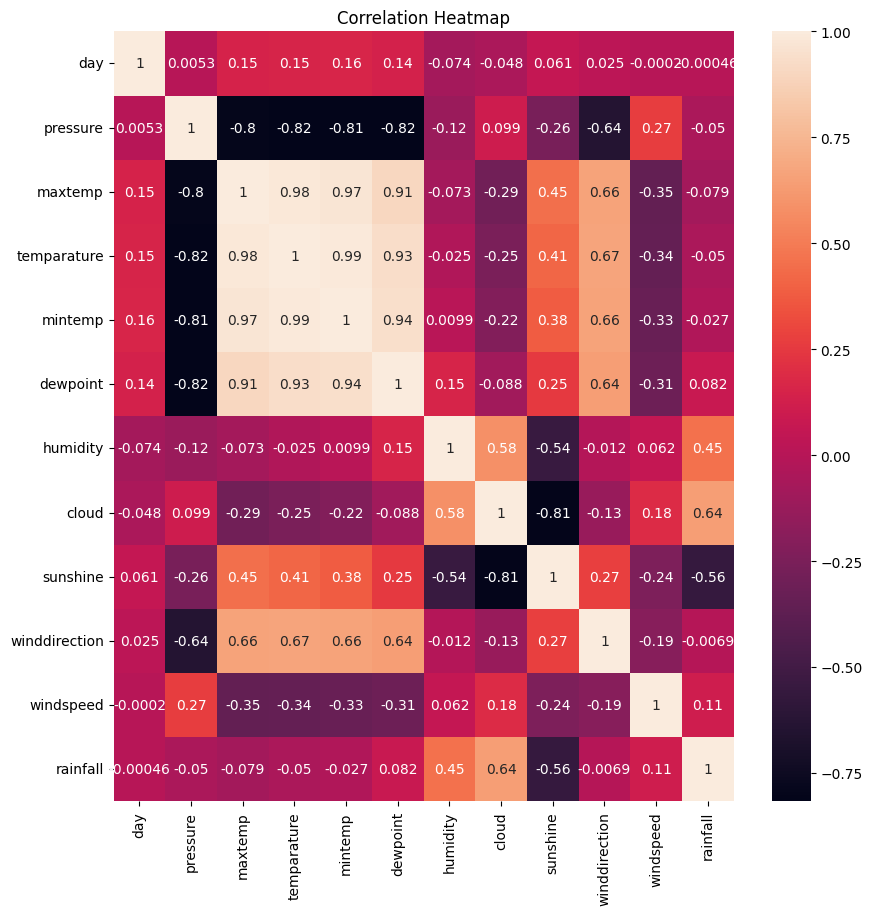

In [19]:
plt.figure(figsize=(10,10))
plt.title("Correlation Heatmap")
sns.heatmap(df_corr,annot=True)

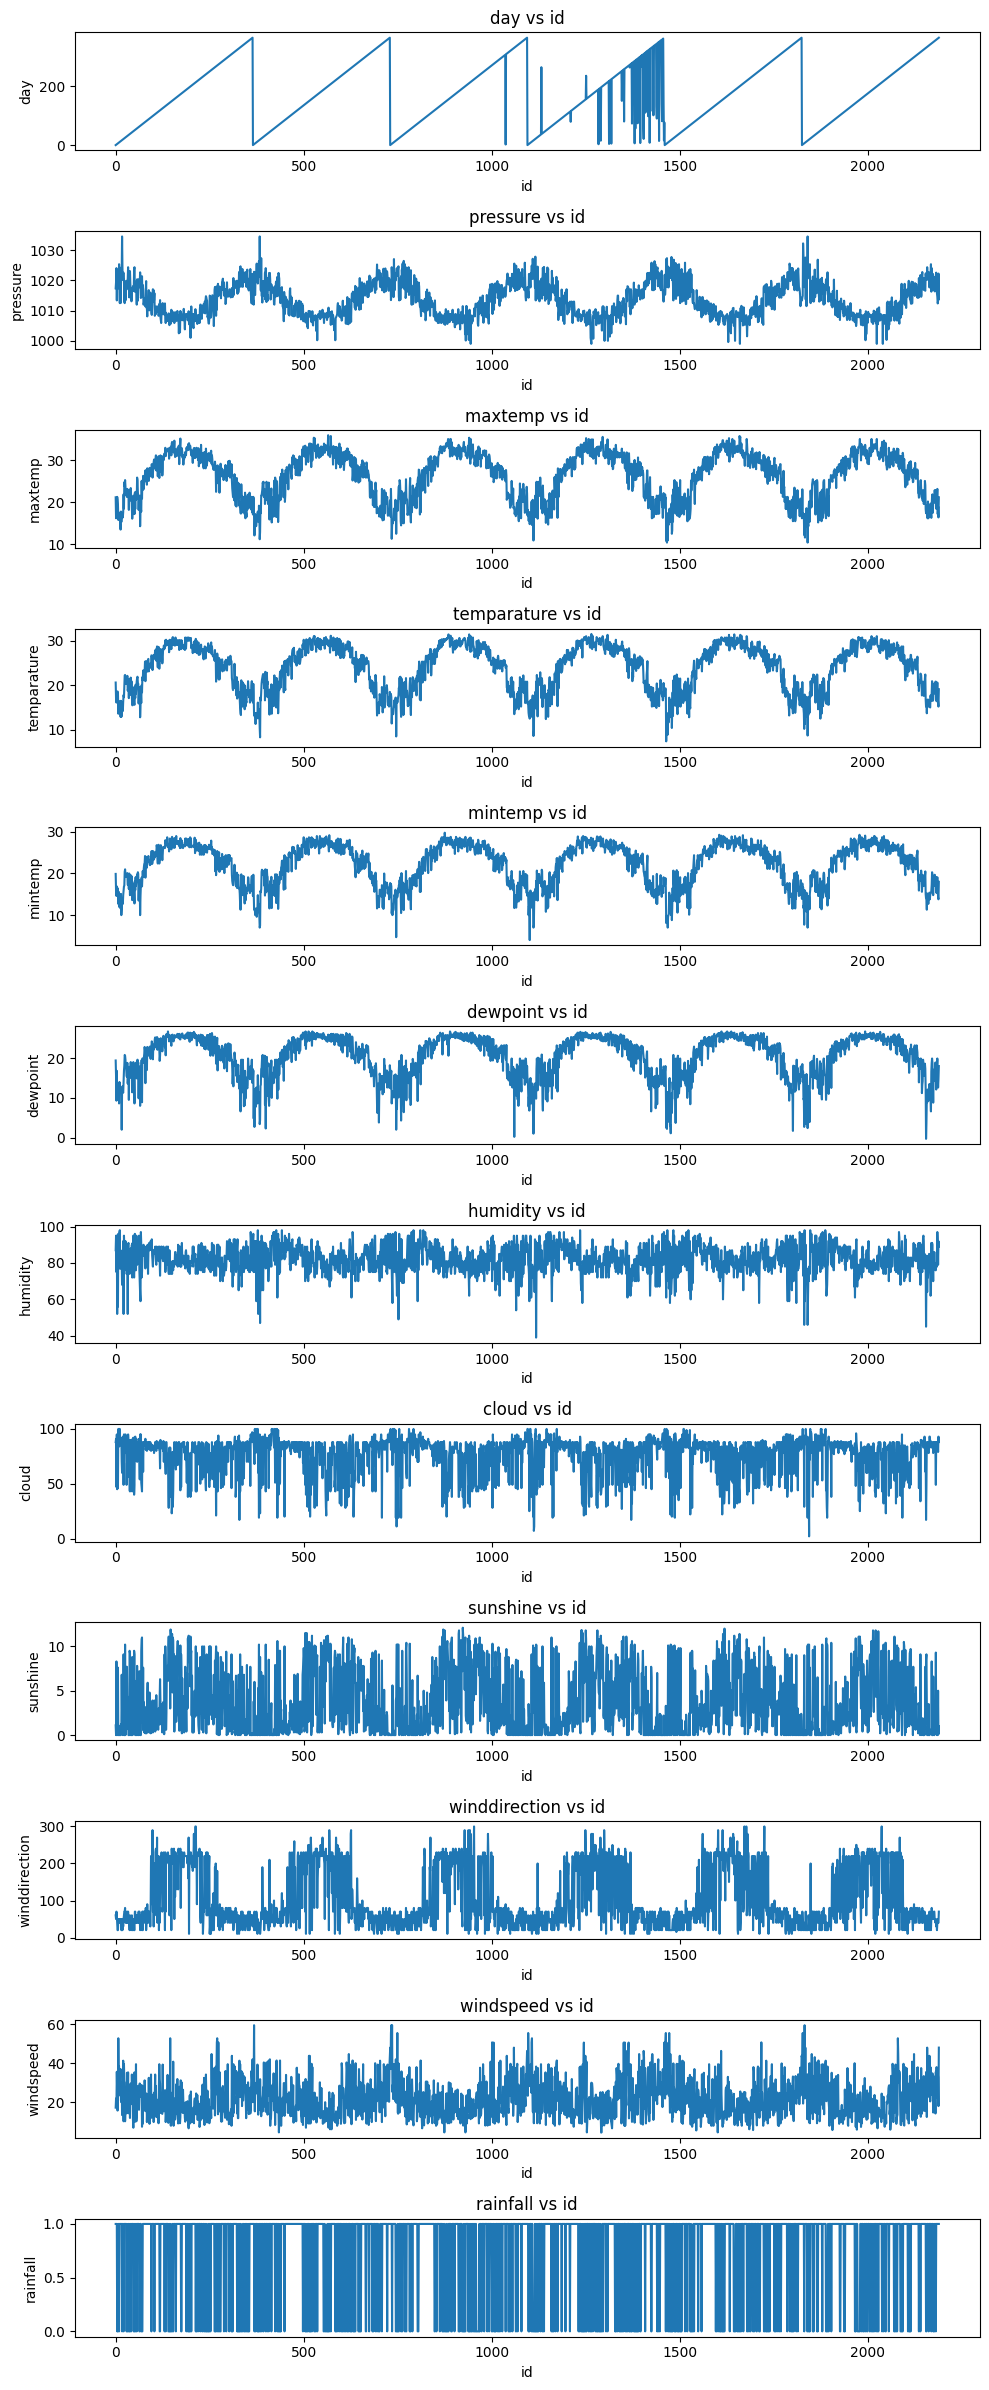

In [20]:

fig,axs = plt.subplots(len(num_cols),1,figsize=(10,2*len(num_cols)))
for i,col in enumerate(num_cols):
    axs[i].set_title(f'{col} vs id')
    sns.lineplot(df,x='id',y=col,ax=axs[i])
plt.tight_layout()
plt.show()

# Observations
1. There are correlations between most features and even to each other
2. Very strong correlation between dewpoint and temperature, temperature and max/min temperature risking multi colinearity
3. Days follow a 1-365 cycle, with some exceptions --> Cyclic encoding will be beneficial
4. No missing values therefore no need to impute

# Preprocessing Function        

In [21]:
df.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall'],
      dtype='object')

# Initialize Models and pipelines

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [23]:
def preprocessor(df):
    X = df.copy()
    


    X['Range'] = X['maxtemp'] - X['mintemp']
    # Calculate average of all temperatures (max/min/temp/dewpoint)
    X['avg_temp'] = (X['maxtemp'] + X['mintemp'] + X['temparature'] + X['dewpoint'])/4
    X = X.drop(columns=['maxtemp','mintemp','dewpoint','temparature','id'])
    
    return X


In [24]:
X = df.drop(columns=['rainfall'])
y = df['rainfall']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=43)

In [37]:
def pipeline_stack(model):

    pipeline_final = Pipeline(steps = [
        ('Preprocessing', FunctionTransformer(preprocessor)),
        ('scaler',StandardScaler()),
        ('model',model)
    ])

    return pipeline_final

def pipeline_fit_and_evaluate(X_train,y_train,X_test,y_test,pipeline):
    pipeline.fit(X_train,y_train)
    y_preds = pipeline.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_preds)
    return roc_auc


In [44]:
def objective(trial):
    params = {
            'iterations': trial.suggest_int('iterations',100,750),
            'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.15),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4.0, 10.0),        
            'verbose': 0,
            'random_seed': 42,
            'loss_function': 'Logloss',
            'task_type': 'GPU',
            'early_stopping_rounds':20
        }
    
    model = CatBoostClassifier(**params)

    full_pipeline = pipeline_stack(model)


    scores = cross_val_score(full_pipeline, X, y, cv=3, scoring='roc_auc', n_jobs=1)
    return scores.mean()

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42)  
)
study.optimize(objective,n_trials = 200)

[I 2025-04-07 17:50:26,659] A new study created in memory with name: no-name-3aae82e8-609a-42d2-aba9-49454dd2864d
[I 2025-04-07 17:50:38,551] Trial 0 finished with value: 0.8714612794612795 and parameters: {'iterations': 343, 'learning_rate': 0.14408571676918994, 'depth': 9, 'l2_leaf_reg': 7.59195090518222}. Best is trial 0 with value: 0.8714612794612795.
[I 2025-04-07 17:50:41,768] Trial 1 finished with value: 0.8854579124579125 and parameters: {'iterations': 201, 'learning_rate': 0.048719342440344315, 'depth': 4, 'l2_leaf_reg': 9.197056874649611}. Best is trial 1 with value: 0.8854579124579125.
[I 2025-04-07 17:50:48,385] Trial 2 finished with value: 0.8720404040404041 and parameters: {'iterations': 491, 'learning_rate': 0.11496870933552546, 'depth': 4, 'l2_leaf_reg': 9.819459112971966}. Best is trial 1 with value: 0.8854579124579125.
[I 2025-04-07 17:51:46,338] Trial 3 finished with value: 0.8774040404040404 and parameters: {'iterations': 641, 'learning_rate': 0.055480693281393136, 

In [46]:
# Get best params from Optuna
def get_acc():
    best_params = study.best_params

    # Create final model with ALL required parameters
    final_params = {
        **best_params,
        'random_state': 42  # Recommended to avoid conflicts
    }

    final_model = CatBoostClassifier(**final_params)

    # Proceed with your pipeline
    pipeline_final = pipeline_stack(final_model)
    accuracy = pipeline_fit_and_evaluate(
        pipeline=pipeline_final,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )
    return accuracy


In [47]:
print(get_acc())

0:	learn: 0.6718003	total: 1.23ms	remaining: 172ms
1:	learn: 0.6512800	total: 2.06ms	remaining: 143ms
2:	learn: 0.6339170	total: 2.65ms	remaining: 122ms
3:	learn: 0.6162201	total: 3.71ms	remaining: 127ms
4:	learn: 0.6002906	total: 4.78ms	remaining: 130ms
5:	learn: 0.5841793	total: 5.92ms	remaining: 133ms
6:	learn: 0.5709047	total: 7.31ms	remaining: 140ms
7:	learn: 0.5581609	total: 8.18ms	remaining: 136ms
8:	learn: 0.5453054	total: 8.86ms	remaining: 130ms
9:	learn: 0.5337801	total: 9.87ms	remaining: 129ms
10:	learn: 0.5229538	total: 10.5ms	remaining: 125ms
11:	learn: 0.5132718	total: 11.2ms	remaining: 120ms
12:	learn: 0.5038611	total: 11.8ms	remaining: 117ms
13:	learn: 0.4945546	total: 12.5ms	remaining: 113ms
14:	learn: 0.4856507	total: 13.1ms	remaining: 110ms
15:	learn: 0.4782385	total: 13.7ms	remaining: 107ms
16:	learn: 0.4707171	total: 14.4ms	remaining: 105ms
17:	learn: 0.4635577	total: 15ms	remaining: 102ms
18:	learn: 0.4573446	total: 15.6ms	remaining: 99.9ms
19:	learn: 0.4509249	to

In [48]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
results = []

In [49]:
def log_run(preprocessor_version,accuracy):
    results.append({"preprocessor_version": preprocessor_version, "accuracy": accuracy})
    for run in results:
        print(run)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [64]:
best_params = study.best_params

    # Create final model with ALL required parameters
final_params = {
        **best_params,
        'random_state': 42  # Recommended to avoid conflicts
}

final_model = CatBoostClassifier(**final_params)

    # Proceed with your pipeline
pipeline_final = pipeline_stack(final_model)

In [ ]:
df_test.head(3)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9


In [65]:
pipeline_final.fit(X_train,y_train)

0:	learn: 0.6718003	total: 2.54ms	remaining: 356ms
1:	learn: 0.6512800	total: 5.3ms	remaining: 369ms
2:	learn: 0.6339170	total: 6.96ms	remaining: 320ms
3:	learn: 0.6162201	total: 8.11ms	remaining: 278ms
4:	learn: 0.6002906	total: 9.46ms	remaining: 257ms
5:	learn: 0.5841793	total: 11.5ms	remaining: 258ms
6:	learn: 0.5709047	total: 21.6ms	remaining: 413ms
7:	learn: 0.5581609	total: 22.7ms	remaining: 377ms
8:	learn: 0.5453054	total: 24.1ms	remaining: 353ms
9:	learn: 0.5337801	total: 25.5ms	remaining: 334ms
10:	learn: 0.5229538	total: 26.7ms	remaining: 315ms
11:	learn: 0.5132718	total: 27.9ms	remaining: 300ms
12:	learn: 0.5038611	total: 29.1ms	remaining: 287ms
13:	learn: 0.4945546	total: 30.2ms	remaining: 274ms
14:	learn: 0.4856507	total: 31ms	remaining: 260ms
15:	learn: 0.4782385	total: 32ms	remaining: 250ms
16:	learn: 0.4707171	total: 32.8ms	remaining: 240ms
17:	learn: 0.4635577	total: 33.5ms	remaining: 229ms
18:	learn: 0.4573446	total: 34.2ms	remaining: 220ms
19:	learn: 0.4509249	total:

Pipeline(steps=[('Preprocessing',
                 FunctionTransformer(func=<function preprocessor at 0x000001F0BF97AFC0>)),
                ('scaler', StandardScaler()),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000001F081F1D750>)])

In [72]:
y_preds = 1 - pipeline_final.predict_proba(df_test)

In [73]:
df_sample['rainfall'] = y_preds

In [74]:
df_sample.to_csv('submission.csv',index=False)